In [348]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
%matplotlib inline

import string
import unicodedata

import json
import nltk
from collections import Counter

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.util import ngrams
from nltk import pos_tag
from nltk import RegexpParser

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve, auc

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

In [14]:
! ls

README.md             imgs                  spark capstone2.ipynb
__pycache__           notfunny.csv          src
data                  reviews.ipynb         unused.py
funny.csv             roc_curve.py          yelp_dataset


## Load and convert data ##

In [13]:
# read in Yelp Reviews
  
data = [json.loads(line) for line in open('yelp_dataset/yelp_academic_dataset_review.json', 'r')]

In [18]:
reviews_df = pd.DataFrame(data)

In [19]:
reviews_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4.0,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02
1,8bFej1QE5LXp4O05qjGqXA,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4.0,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25
2,NDhkzczKjLshODbqDoNLSg,eC5evKn1TWDyHCyQAwguUw,_sS2LBIGNT5NQb6PD1Vtjw,5.0,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06
3,T5fAqjjFooT4V0OeZyuk1w,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2.0,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15
4,sjm_uUcQVxab_EeLCqsYLg,0kA0PAJ8QFMeveQWHFqz2A,8zehGz9jnxPqXtOc7KaJxA,4.0,0,0,0,The food is always great here. The service fro...,2011-07-28 18:05:01


In [20]:
len(reviews_df)

8635403

In [21]:
# pickle dataframe
reviews_df.to_pickle("./data/reviews.pkl")

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4.0,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02
1,8bFej1QE5LXp4O05qjGqXA,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4.0,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25
2,NDhkzczKjLshODbqDoNLSg,eC5evKn1TWDyHCyQAwguUw,_sS2LBIGNT5NQb6PD1Vtjw,5.0,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06
3,T5fAqjjFooT4V0OeZyuk1w,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2.0,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15
4,sjm_uUcQVxab_EeLCqsYLg,0kA0PAJ8QFMeveQWHFqz2A,8zehGz9jnxPqXtOc7KaJxA,4.0,0,0,0,The food is always great here. The service fro...,2011-07-28 18:05:01


In [22]:
reviews_df = pd.read_pickle("./data/reviews.pkl")
reviews_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4.0,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02
1,8bFej1QE5LXp4O05qjGqXA,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4.0,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25
2,NDhkzczKjLshODbqDoNLSg,eC5evKn1TWDyHCyQAwguUw,_sS2LBIGNT5NQb6PD1Vtjw,5.0,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06
3,T5fAqjjFooT4V0OeZyuk1w,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2.0,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15
4,sjm_uUcQVxab_EeLCqsYLg,0kA0PAJ8QFMeveQWHFqz2A,8zehGz9jnxPqXtOc7KaJxA,4.0,0,0,0,The food is always great here. The service fro...,2011-07-28 18:05:01


In [358]:
if 'reviews_df' in globals():
  # myVar exists

SyntaxError: unexpected EOF while parsing (<ipython-input-358-d7973bc971e5>, line 2)

In [25]:
# train test split on unbalanced data
# 340864/8635403 = 0.0395 

# create 'funny or not' column

reviews_df['funny or not'] = (reviews_df.funny >= 3).astype(int)
#X_train, X_test, y_train, y_test = train_test_split(new_df['text'], new_df['funny or not'], test_size=0.2, random_state=0)


In [28]:
reviews_df['funny or not'].value_counts()

0    8294539
1     340864
Name: funny or not, dtype: int64

In [48]:
X_train, X_test, y_train, y_test = train_test_split(reviews_df['text'], reviews_df['funny or not'], test_size=0.2, stratify = reviews_df['funny or not'], random_state=42)


In [49]:
y_test.value_counts()

0    1658908
1      68173
Name: funny or not, dtype: int64

In [50]:
y_train.value_counts()

0    6635631
1     272691
Name: funny or not, dtype: int64

In [54]:
X_train.head()

4951245    This post office has failed to deliver, redeli...
5801500    If you have ANY interest in food or the enviro...
8323989    Family style no frills restaurant. Order at th...
2893006    Surprise discovery after breakfast New Year's ...
3275211    Whenever I'm in town, I make sure to stop by t...
Name: text, dtype: object

In [62]:
X_train.sample(n=10, random_state=42)

8156155    Don't listen to the other reviews who say that...
5431618    Super authentic Korean food. Prices may seem s...
1333214    Umlauf Garden is another magical hidden gem th...
2831524    The place is hit or miss. Not best when crowde...
5183817    Nice atmosphere definitely very friendly staff...
4806181    Amazing. Unique flavors and all delicious! A l...
2766356    My first visit was great.  Dr. Stamboly was fr...
1152941    In my experience, it is a rarity indeed for an...
6475480    Amanda is awesome! I decided to get a haircut ...
5345419    This place was okay. We went directly upstairs...
Name: text, dtype: object

In [63]:
y_train.sample(n=10, random_state=42)

8156155    1
5431618    0
1333214    0
2831524    0
5183817    0
4806181    0
2766356    0
1152941    0
6475480    0
5345419    0
Name: funny or not, dtype: int64

In [90]:
pd.concat([X_train,y_train[y_train == 1]])

4951245    This post office has failed to deliver, redeli...
5801500    If you have ANY interest in food or the enviro...
8323989    Family style no frills restaurant. Order at th...
2893006    Surprise discovery after breakfast New Year's ...
3275211    Whenever I'm in town, I make sure to stop by t...
                                 ...                        
3932073                                                    1
2795946                                                    1
5027201                                                    1
3351677                                                    1
6176732                                                    1
Length: 7181013, dtype: object

In [100]:
# balance train data
X_train_funny = X_train[y_train == 1]
X_train_not_funny = X_train[y_train == 0].sample(n=len(X_train_funny), random_state=42)

y_train_funny = y_train[y_train == 1]
y_train_not_funny = y_train[y_train == 0].sample(n=len(y_train_funny), random_state=42)

In [102]:
X_train_not_funny

3727798    First time here by myself sitting at the bar. ...
5418802    Love Cafeteria, love their patio & cocktail me...
1873812    I'm a fan of One Line Coffee. If it weren't fo...
5357040    Love their sushi and they always have friendly...
8551334    A Japanese fusion restaurant with some influen...
                                 ...                        
34116      There's an older review that suggests going to...
8319942    Excellent Bestbuy is the best place for all el...
8378259    This is the only store I know in Austin that s...
7472430    Ok, so I finally went to see what all the hub-...
699022     The always work with me on price and outstandi...
Name: text, Length: 272691, dtype: object

In [105]:
X_train_funny

5636821    2017's Yelp 100 Challenge 18/100\n\nWhat a fun...
6543303    We recently leased a new car from here. We had...
248221     If I could give this place one star I would. D...
3163591    So I seriously considered trying to impress yo...
4980874    I went here based off the reviews, and the fac...
                                 ...                        
3932073    Hands down my favorite restaurant in Portland....
2795946    I got to Atlanta a 6:06 am on Sunday after tak...
5027201    I had never heard of Donut King until almost t...
3351677    My wife and I decided to refinance our home an...
6176732    First off let me start by saying I loooooooooo...
Name: text, Length: 272691, dtype: object

In [104]:
y_train_funny

5636821    1
6543303    1
248221     1
3163591    1
4980874    1
          ..
3932073    1
2795946    1
5027201    1
3351677    1
6176732    1
Name: funny or not, Length: 272691, dtype: int64

In [107]:
X_train_balanced = pd.concat([X_train_funny, X_train_not_funny])

In [108]:
y_train_balanced = pd.concat([y_train_funny, y_train_not_funny])

In [124]:
X_train_balanced.to_csv('X_train_balanced.csv')

In [126]:
y_train_balanced.to_csv('y_train_balanced.csv')

In [128]:
y_train_balanced.value_counts()

0    272691
1    272691
Name: funny or not, dtype: int64

In [129]:
# read in data
X_train_balanced_df = pd.read_csv('X_train_balanced.csv')
y_train_balanced_df = pd.read_csv('y_train_balanced.csv')

In [133]:
X_train_balanced_df = X_train_balanced_df.drop(['Unnamed: 0'], axis = 1)
y_train_balanced_df = y_train_balanced_df.drop(['Unnamed: 0'], axis = 1)

In [134]:
X_train_balanced_df

,text
0,2017's Yelp 100 Challenge 18/100\n\nWhat a fun...
1,We recently leased a new car from here. We had...
2,If I could give this place one star I would. D...
3,So I seriously considered trying to impress yo...
4,"I went here based off the reviews, and the fac..."
...,...
545377,There's an older review that suggests going to...
545378,Excellent Bestbuy is the best place for all el...
545379,This is the only store I know in Austin that s...
545380,"Ok, so I finally went to see what all the hub-..."


In [135]:
y_train_balanced_df

,funny or not
0,1
1,1
2,1
3,1
4,1
...,...
545377,0
545378,0
545379,0
545380,0


In [119]:
X_test

7938342    After a long night of shopping and not wanting...
1022903    The Meatballer Calzone was amazing. The best p...
1555583    I wish I would have taken a picture of what I'...
2316906    The food is reasonable and tastes pretty fresh...
8189224    Very good but kind of expensive.\n\nI really l...
                                 ...                        
8594701    I dunno what they be putting in their spicy sa...
2833077    Finally got to come out and try this place, I ...
5953231    We ordered King Bao for delivery the other nig...
8464444    Super friendly staff and pretty good food! I l...
8158227    Delicious soups, excellent lunch menu.... brin...
Name: text, Length: 1727081, dtype: object

In [121]:
y_test.value_counts()

0    1658908
1      68173
Name: funny or not, dtype: int64

In [118]:
## add column for review length

pd.DataFrame(X_train_balanced).text

,text
5636821,2017's Yelp 100 Challenge 18/100\n\nWhat a fun...
6543303,We recently leased a new car from here. We had...
248221,If I could give this place one star I would. D...
3163591,So I seriously considered trying to impress yo...
4980874,"I went here based off the reviews, and the fac..."
...,...
34116,There's an older review that suggests going to...
8319942,Excellent Bestbuy is the best place for all el...
8378259,This is the only store I know in Austin that s...
7472430,"Ok, so I finally went to see what all the hub-..."


In [ ]:
X_train_df['review length'] = len(X_train_df.text)

In [82]:
## old code

In [496]:
# get 200k dataframe of balanced funny/not funny reviews

len(reviews_df[reviews_df.funny >= 3])

340864

In [497]:
funny_df = reviews_df[reviews_df.funny >= 3].sample(n=100000, random_state=1)
not_funny_df = reviews_df[reviews_df.funny < 3].sample(n=100000, random_state=1)

In [498]:
# save datasets to csv

funny_df.to_csv('funny.csv')
not_funny_df.to_csv('notfunny.csv')

In [3]:
# read in and concatenate

funny_df = pd.read_csv('funny.csv')
not_funny_df = pd.read_csv('notfunny.csv')

df = pd.concat([funny_df, not_funny_df]).drop_duplicates('review_id')
df.shape

(200000, 10)

In [4]:
df = df.drop(['Unnamed: 0'], axis = 1)

In [5]:
df = df.reset_index(drop=True)

In [6]:
df.text

0         A scavenger hunt was hosted by the Paramount r...
1         The Pretty Kitty has 20 locations throughout t...
2         After a very productive business meeting this ...
3         I called in advance to be sure that they had t...
4         Eastern Standard reminds me of that scene in S...
                                ...                        
199995    Very mediocre korean food but great if you're ...
199996    Horrible, I sat at the drive up ordering thing...
199997    COULDN'T BE HAPPIER!  I just got my second tat...
199998    Pizza that's a commodity. They make a certain ...
199999    Very consistent the best coffee good sandwiche...
Name: text, Length: 200000, dtype: object

In [7]:
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,DEECPhn5tNBKbuaOeIcd2w,CwBh8Fmr07jFYBKZ2p6Mqg,iNsMwBxFXcP7QvB3994mgA,5.0,3,4,4,A scavenger hunt was hosted by the Paramount r...,2009-07-31 02:33:55
1,Ja7ZM1i_gYFXmxrkJPEPlA,ncIHRw4Vx3Wh9mZhLZxB7g,dgprzdonZcF7PPt-hkUkag,5.0,15,3,6,The Pretty Kitty has 20 locations throughout t...,2015-08-04 00:01:50
2,9E8ZAppLWtL0oJYRbFmOFQ,mdP18-vCtV9nu8DT2Bk6lA,gYuTx4cB_5UutuWIGusmUQ,5.0,14,6,9,After a very productive business meeting this ...,2018-10-15 13:49:54
3,MHBTWs3E8bKR80SOpcelWw,fV4Y0rKuJaahlNfjCH3vfw,ZM3Y7pPuKu67Q_FOLqGx7A,4.0,1,4,0,I called in advance to be sure that they had t...,2012-08-25 01:39:58
4,EcvcH3hHuzlXqG79nIag0w,ys3M-lvO7wCYkhCbqSVCfA,p8ohzzGvGRCHnJKnyO7exA,4.0,0,4,0,Eastern Standard reminds me of that scene in S...,2014-11-08 23:22:35


In [509]:
max(df.funny)

610

In [512]:
len(df[df.funny != 610])

199999

In [528]:
len(df[df.funny < 3])

100000

In [567]:
# get review with 3 funny votes
df[df.funny == 100].iloc[1].text

'Let\'s say I marry a nice lass. Soon, she\'s showing the bump and nine months later, we\'re in Dave\'s Fresh Pasta and she looks at me and says "It\'s time." I try to keep my cool but I freak out and we rush to the hospital. I\'ve got the video camera (which I think is creepy, but her mom wants all the magic recorded) and my scrubs, she\'s in a gurney on her back flawlessly executing on all the Lamaze training we\'ve gone through. The docs and nurses are hovered around her and she\'s at the point of sweating where her hair is all pasted to her wincing face. And then, everything goes quiet except for one nurse who gasps, "Oh my..."\n\nAnd the doc turns around to show me my baby Dave\'s Cuban Sandwich. Everyone\'s embarassed, she\'s looking at me with the "I\'m so sorry" face, and I\'m in a little shock but you know what? I\'m not mad. With the crusty chewy bread, thick slices of pork loin, ham, fresh pickles, swiss and that amazing chipotle aioli, I know how irresistable it can be.\n\n

In [554]:
df[df.funny == 2].iloc[15].text

'Although there may be plenty of tourists, the large array of shops and restaurants make it a pleasurable place to spend your time here. Not pleasurable if you are driving though because you probably won\'t find parking here. The cobblestone streets are cool, but I got lost here! Thank goodness I had my Iphone, and used the GPS. The square often attracts activists, street dwellers, goth subcultures, street performers, conservatives, tourists you name it! They have it.\n\nA cool thing to do is to check out "The Garage". It\'s a small shopping mall that used to be a parking garage.\n\nI\'m not a fan of the national chains in the square though like Urban Outfitters (See my review and find out why) and corporate banks like Bank of America. I would rather support the small locally-run businesses with unique styles. It\'s one of the reasons why I dislike gentrification.\n\nBecause of high rent, the small, independent mom & pop stores suffer, and it changes the culturally heterogeneous charac

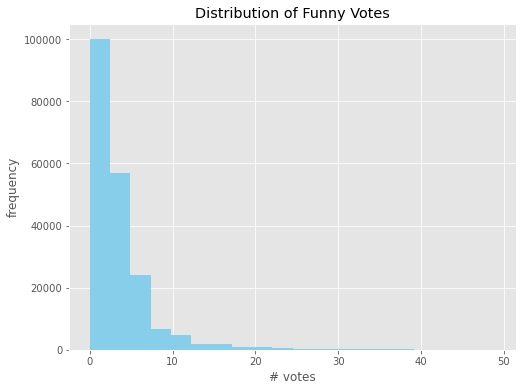

In [562]:
# Histogram of funny column to show class imbalances

fig, ax = plt.subplots(figsize = (8,6))

ax.hist(df[df.funny < 50].funny, bins = 20, color = 'skyblue')
ax.set_title('Distribution of Funny Votes')
ax.set_xlabel('# votes')
ax.set_ylabel('frequency')
plt.savefig('funnyhist.png')

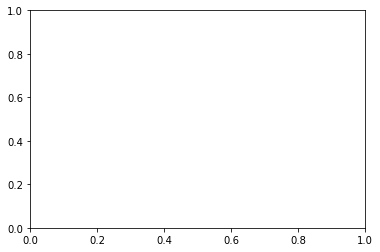

In [55]:
# Barchart of funny vs not funny

fig, ax = plt.subplots()


In [41]:
max(df.funny)

610

In [30]:
(reviews[0]['text'])

"I loved everything about this place. I've only been once but I keep meaning to go back as it was so great (just a bit out of my way). \n\nI went with a fairly large group so we'd all ordered something different (back when it was $6 for everything, it looks like they've changed that now). At the time I got the chickpea fries, which were delicious but watch out for the fiber because I had to sit out of an entire board game. The board game selection was great, and I love that they serve mead (though I didn't get any at 12 pm haha).  The molten lava chocolate cake was so, so good. Seriously.\n\nThe real topping to the experience (other than the great service and the fact that they put lemons in their complimentary ice water) was that they were playing Siouxsie and the Banshees in the background! That + board games + good food + mead = I'm a fan forever."

## Text Processing Pipeline ##

In [7]:
# create new df of just text and label

new_df = pd.concat([df.text, df.funny], axis=1)


In [8]:
new_df['funny or not'] = (new_df.funny >= 3).astype(int)


In [9]:
new_df = new_df.drop(columns ='funny')


In [10]:
new_df.head()


,text,funny or not
0,A scavenger hunt was hosted by the Paramount r...,1
1,The Pretty Kitty has 20 locations throughout t...,1
2,After a very productive business meeting this ...,1
3,I called in advance to be sure that they had t...,1
4,Eastern Standard reminds me of that scene in S...,1


In [13]:
# save to csv

new_df.sample(n=20, random_state=1).to_csv('example_data.csv')

In [15]:
# create toy df for faster processing


In [48]:
toy_funny = funny_df.sample(n=10000, random_state=1)
toy_notfunny = not_funny_df.sample(n=10000, random_state=1)

toy_df = pd.concat([toy_funny, toy_notfunny]).drop_duplicates('review_id')
toy_df = toy_df.drop(['Unnamed: 0'], axis = 1)


In [51]:
toy_df.funny

43660     4
87278     3
14317     3
81932     3
95321    21
         ..
59828     0
47957     0
42429     0
76505     0
49578     0
Name: funny, Length: 20000, dtype: int64

In [52]:
toy = pd.concat([toy_df.text, toy_df.funny], axis=1)

toy['funny or not'] = (toy.funny >= 3).astype(int)
toy = toy.drop(columns ='funny')


In [ ]:
# gensim library for word vectors - come back if time


In [254]:
# Tokenization (don't filter stopwords or punctuation as these may contribute to humor)

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

#tokens = review_text.map(word_tokenize)

#tokenized = [word_tokenize(review_text.lower()) for review in review_text]

# lowercase and tokenize
toy_df['tokens'] = toy_df['text'].str.lower().map(word_tokenize)


In [175]:
type(toy_df)


pandas.core.frame.DataFrame

In [676]:
# stemming/lemmatization

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

porter = PorterStemmer()
snowball = SnowballStemmer('english')
wordnet = WordNetLemmatizer()

# docs_porter = [[porter.stem(word) for word in words]
#                for doc in toy_tokens]
# docs_snowball = [[snowball.stem(word) for word in words]
#                  for doc in toy_tokens]
# docs_wordnet = [[wordnet.lemmatize(word) for word in words]
#                 for doc in toy_tokens]

# tokens_porter = [list(map(porter.stem, doc)) for doc in toy_df['tokens']]

# tokens_snowball = [list(map(snowball.stem, doc)) for doc in toy_df['tokens']]

# tokens_wordnet = [list(map(wordnet.lemmatize, doc)) for doc in toy_df['tokens']]


In [191]:
# stem/lemmatize within dataframe

type(tokens_porter)


list

In [194]:
len(tokens_wordnet[0])


186

In [195]:
## Print the stemmed and lemmatized words from the first review for each method
print("%16s %16s %16s %16s" % ("word", "porter", "snowball", "lemmatizer"))

for i in range(min(len(tokens_porter[0]), len(tokens_snowball[0]), len(tokens_wordnet[0]))):
    p, s, w = tokens_porter[0][i], tokens_snowball[0][i], tokens_wordnet[0][i]
    if len(set((p, s, w))) != 1:
        print("%16s %16s %16s %16s" % (toy_df['tokens'][0][i], p, s, w))


            word           porter         snowball       lemmatizer
       scavenger          scaveng          scaveng        scavenger
             was               wa              was               wa
          hosted             host             host           hosted
        recently           recent           recent         recently
            plus              plu             plus             plus
         running              run              run          running
             was               wa              was               wa
         totally            total            total          totally
        watching            watch            watch         watching
      afterwards        afterward        afterward       afterwards
          lovely             love             love           lovely
         sitting              sit              sit          sitting
        charming            charm            charm         charming
        marveled           marvel           marv

In [673]:
# bag of words, max features 3000
# TF-IDF
# will go with lemmatizer to preserve as much of the original word as possible

from sklearn.feature_extraction.text import TfidfVectorizer

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode()

def tokenize(doc):
    '''
    INPUT: string
    OUTPUT: list of strings

    Remove accents, tokenize, and lemmatize the document.
    '''
    doc = remove_accents(doc)
    return [wordnet.lemmatize(word) for word in word_tokenize(doc)]


#tfidfvect = TfidfVectorizer(tokenizer=tokenize)

# features
#tfidf_vectorized = tfidfvect.fit_transform(toy_df.text)



In [ ]:
# latent semantic analysis - capstone 3


## TF-IDF Vectorization / EDA ##

In [83]:
# baseline models on top of TF-IDF

# train models on toy dataset of 20k

#X_train, X_test, y_train, y_test = train_test_split(new_df['text'], new_df['funny or not'], test_size=0.2, random_state=0)


In [92]:
# vectorize train data/transform test data

tfidfvect = TfidfVectorizer(max_features = 3000, 
                            sublinear_tf=True, 
                            min_df=5, norm='l2', 
                            encoding='latin-1') 
                            #ngram_range=(1, 3))

# try max features 3000, 10000 etc. to see if improving
# n-grams: 1, 2, 3
# stopwords 
# stemming, lemma etc.

In [122]:
X_train_tfidf = tfidfvect.fit_transform(X_train_balanced)
X_test_tfidf = tfidfvect.transform(X_test)

# get vocab
words = tfidfvect.get_feature_names()

In [123]:
X_train_tfidf.shape, X_test_tfidf.shape


((545382, 3000), (1727081, 3000))

In [137]:
X_train_tfidf

<545382x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 44849205 stored elements in Compressed Sparse Row format>

In [136]:
vocab_dict = tfidfvect.vocabulary_
vocab_dict

{'yelp': 2984,
 '100': 3,
 'challenge': 462,
 '18': 11,
 'what': 2905,
 'fun': 1097,
 'place': 1942,
 'to': 2682,
 'spend': 2450,
 'any': 125,
 'night': 1733,
 'my': 1698,
 'friend': 1083,
 'and': 115,
 'had': 1198,
 'by': 400,
 'this': 2652,
 'location': 1524,
 'several': 2314,
 'times': 2675,
 'finally': 1015,
 'one': 1794,
 'we': 2880,
 'couldn': 638,
 'agree': 81,
 'on': 1792,
 'do': 795,
 'so': 2402,
 'decided': 724,
 'stop': 2514,
 'in': 1335,
 'grab': 1162,
 'bite': 292,
 'upon': 2791,
 'entering': 892,
 'you': 2993,
 'are': 155,
 'greeted': 1174,
 'waitress': 2849,
 'who': 2917,
 'says': 2250,
 'the': 2634,
 'seat': 2271,
 'yourself': 2996,
 'anywhere': 132,
 'did': 759,
 'at': 179,
 'of': 1773,
 'many': 1579,
 'tables': 2575,
 'located': 1523,
 'just': 1406,
 'above': 40,
 'right': 2180,
 'stage': 2472,
 'they': 2644,
 'have': 1229,
 'karaoke': 1408,
 'full': 1095,
 'bar': 222,
 'kitchen': 1427,
 'drinks': 833,
 'amazing': 105,
 'food': 1054,
 'hit': 1277,
 'or': 1810,
 'miss'

In [86]:
from collections import Counter
dict(Counter(vocab_dict).most_common(50))

{'zero': 2999,
 'yummy': 2998,
 'yum': 2997,
 'yourself': 2996,
 'your own': 2995,
 'your': 2994,
 'young': 2993,
 'you would': 2992,
 'you won': 2991,
 'you will': 2990,
 'you want to': 2989,
 'you want': 2988,
 'you ve': 2987,
 'you to': 2986,
 'you the': 2985,
 'you should': 2984,
 'you re looking': 2983,
 'you re in': 2982,
 'you re': 2981,
 'you need to': 2980,
 'you need': 2979,
 'you might': 2978,
 'you may': 2977,
 'you ll': 2976,
 'you like': 2975,
 'you know': 2974,
 'you just': 2973,
 'you have to': 2972,
 'you have': 2971,
 'you go': 2970,
 'you get': 2969,
 'you feel': 2968,
 'you don': 2967,
 'you do': 2966,
 'you could': 2965,
 'you can get': 2964,
 'you can': 2963,
 'you are': 2962,
 'you and': 2961,
 'you': 2960,
 'yet': 2959,
 'yesterday': 2958,
 'yes': 2957,
 'yelp': 2956,
 'years and': 2955,
 'years ago': 2954,
 'years': 2953,
 'year old': 2952,
 'year': 2951,
 'yeah': 2950}

In [104]:
# plot most common words

data = dict(Counter(vocab_dict).most_common(30))
word_df = pd.DataFrame.from_dict(data, orient='index', columns = ['count'])


In [105]:
word_df

,count
zero,2999
yummy,2998
yum,2997
yourself,2996
your own,2995
your,2994
young,2993
you would,2992
you won,2991
you will,2990


In [109]:
word_df.reset_index()
word_df.index.name = 'token'
word_df

,count
token,
zero,2999
yummy,2998
yum,2997
yourself,2996
your own,2995
your,2994
young,2993
you would,2992
you won,2991


Text(0.5, 1.0, 'Most Common Words/Phrases')

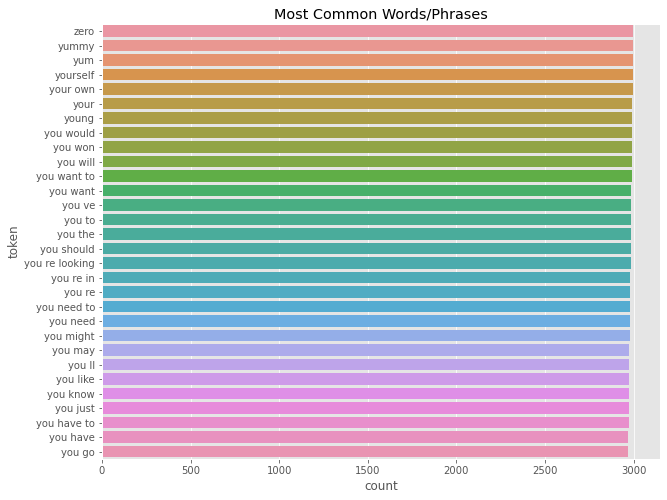

In [115]:
plt.figure(figsize=(10,8))
ax = sns.barplot(x='count', y=word_df.index, data=word_df)
ax.set_title("Most Common Words/Phrases")
#plt.show()
#plt.savefig('mostcommon', bbox_inches='tight')
#ax = sns.barplot(x=counts.counts, y=counts.index, data=counts)

In [116]:
# correlation for next time

## Modeling ##

In [151]:
ls

README.md              funny_reviews.csv      spark capstone2.ipynb
Untitled.ipynb         imgs/                  src/
X_train_balanced.csv   not_funny_reviews.csv  unused.py
__pycache__/           notfunny.csv           y_train_balanced.csv
data/                  reviews.ipynb          yelp_dataset/
funny.csv              roc_curve.py


In [152]:
## modeling from py file
import sys, importlib
#importlib.reload(sys.modules['mymodels'])
from src.mymodels import *


In [153]:
# logistic regression

y_pred_lr, y_proba_lr = log_reg_model(X_train_tfidf, X_test_tfidf, y_train_balanced)

In [154]:
# naive bayes

y_pred_nb, y_proba_nb = naive_bayes_model(X_train_tfidf, X_test_tfidf, y_train_balanced)

In [648]:
# random forest

y_pred_rf, y_proba_rf = random_forest_model(X_train_tfidf, X_test_tfidf, y_train_balanced)

In [653]:
# gradient boosting
# ran for > 1hr

y_pred_gbc, y_proba_gbc = gradient_boosting_model(X_train_tfidf, X_test_tfidf, y_train_balanced)

In [156]:
# calculate scores

accuracy_scores = []
precision_scores = []
recall_scores = []

y_preds = [y_pred_lr, y_pred_nb]#, y_pred_rf, y_pred_gbc]

for y_pred in y_preds:
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    
    precision = precision_score(y_test, y_pred)
    precision_scores.append(precision)
    
    recall = recall_score(y_test, y_pred)
    recall_scores.append(recall)
    
# print("Accuracy:", accuracy_score(y_test, y_pred_lr_test))
# print("Precision:", precision_score(y_test, y_pred_lr_test))
# print("Recall:", recall_score(y_test, y_pred_lr_test))


In [157]:
accuracy_scores

[0.7508941387230825, 0.703791541913784]

In [158]:
precision_scores

[0.108644660294922, 0.09068250507258552]

In [160]:
recall_scores

[0.7371686738151467, 0.7204758482097018]

In [ ]:
# calculate confusion matrices for different thresholds
# come back to this later

def predict(model, X, threshold=0.5):
    '''Return prediction of the fitted binary-classifier model model on X using
    the specifed `threshold`. NB: class 0 is the positive class'''
    return np.where(model.predict_proba(X)[:, 0] > threshold,
                    model.classes_[0],
                    model.classes_[1])

def confusion_matrix(model, X, threshold=0.5):
    cf = pd.crosstab(ytest, predict(model, Xtest, threshold))
    cf = cf.add(pd.DataFrame([[0,0],[0,0]], columns=['Fraud', 'Not'], index=['Fraud', 'Not']), fill_value=0)
    cf.index.name = 'actual'
    cf.columns.name = 'predicted'
    return cf

In [147]:
def plot_ROC(ax, fpr, tpr):
    ax.plot([1]+list(fpr), [1]+list(tpr), label="ROC")
    ax.plot([0,1],[0,1], 'k', label="random")
    ax.set_xlabel('fpr')
    ax.set_xlabel('fpr')
    ax.set_ylabel('tpr')
    ax.set_title('ROC Curve')
    ax.legend()

0.8378488873055842
0.7962700897399655
0.7751337275144112
0.8266901765832771


<ipython-input-667-fb5df8d00f95>:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('roccurves.png', bbox='tight')


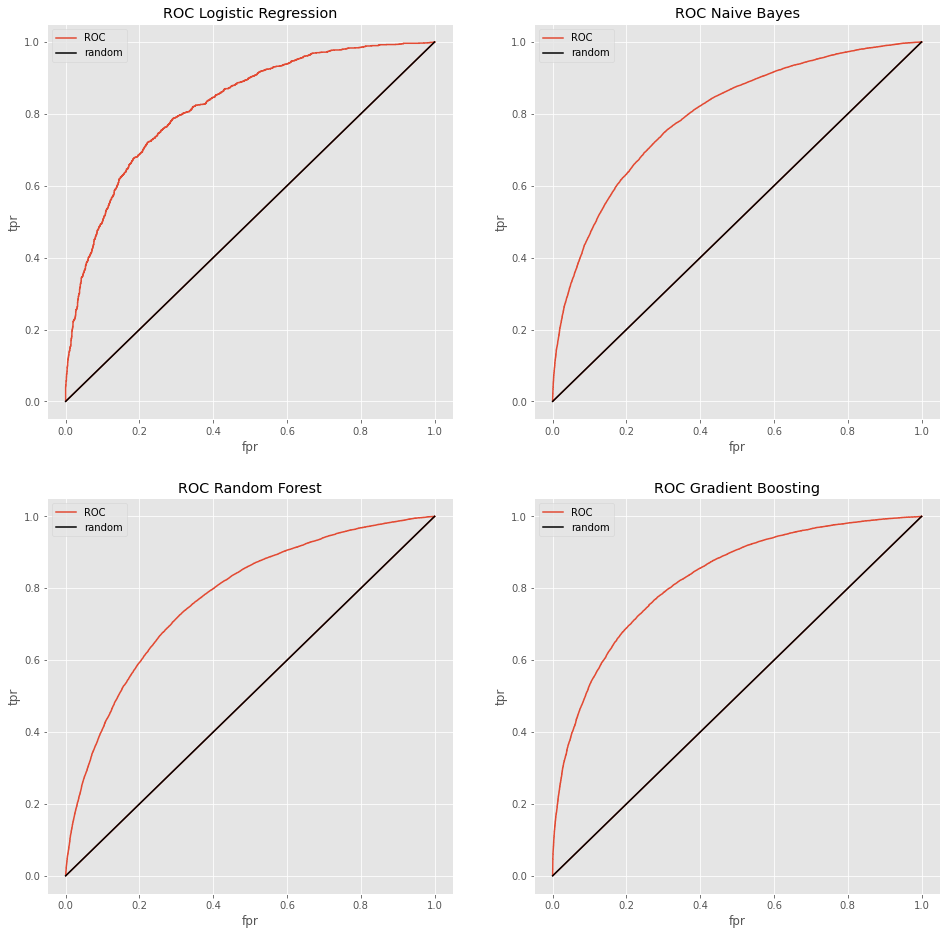

In [667]:
# calculate AUC

# ROC curves
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2, figsize = (16,16))

fpr0, tpr0, threshold0 = roc_curve(y_test, y_proba_lr)
plot_ROC(ax0, fpr, tpr)
ax0.title.set_text('ROC Logistic Regression')
print(auc(fpr0, tpr0))

fpr1, tpr1, threshold1 = roc_curve(y_test, y_proba_nb)
plot_ROC(ax1, fpr1, tpr1)
ax1.title.set_text('ROC Naive Bayes')
print(auc(fpr1, tpr1))

fpr2, tpr2, threshold2 = roc_curve(y_test, y_proba_rf)
plot_ROC(ax2, fpr2, tpr2)
ax2.title.set_text('ROC Random Forest')
print(auc(fpr2, tpr2))

fpr3, tpr3, threshold3 = roc_curve(y_test, y_proba_gbc)
plot_ROC(ax3, fpr3, tpr3)
ax3.title.set_text('ROC Gradient Boosting')
print(auc(fpr3, tpr3))

plt.savefig('roccurves.png', bbox='tight')

### Logistic Regression ###

In [387]:
# Cross validation
print(cross_val_score(lr, X_train_tfidf, y_train, cv=5))


[0.76      0.7509375 0.751875  0.751875  0.7559375]


In [694]:
# confusion matrix

confusion_matrix(y_test, y_pred_lr)
# true positive, false negative
# false positive, true negative

array([[15368,  4695],
       [ 4947, 14990]])

In [143]:
lr = LogisticRegression(random_state=0, max_iter = 500)
lr.fit(X_train_tfidf, y_train_balanced)


LogisticRegression(max_iter=500, random_state=0)

In [144]:
y_pred_lr_test = lr.predict(X_test_tfidf)
y_proba_lr_test = lr.predict_proba(X_test_tfidf)[:,1]

In [145]:
print("Accuracy:", accuracy_score(y_test, y_pred_lr_test))
print("Precision:", precision_score(y_test, y_pred_lr_test))
print("Recall:", recall_score(y_test, y_pred_lr_test))

Accuracy: 0.7508941387230825
Precision: 0.108644660294922
Recall: 0.7371686738151467


0.8211722171368615


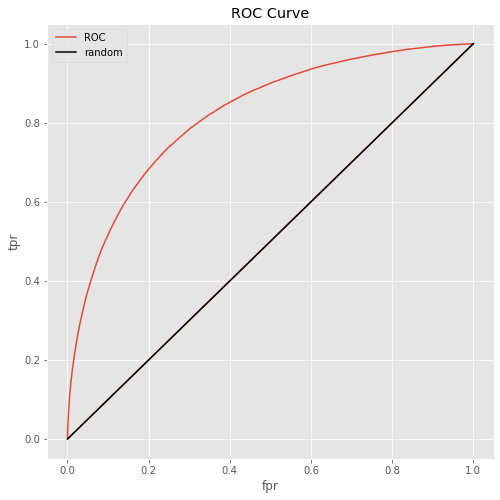

In [148]:
fig, ax = plt.subplots(figsize = (8,8))

fpr, tpr, threshold = roc_curve(y_test, y_proba_lr_test)
plot_ROC(ax, fpr, tpr)
print(auc(fpr, tpr))

In [96]:
lr.coef_[0]


array([ 0.74175077, -0.34679478,  0.32653178, ..., -0.26862264,
       -0.38449224,  0.86775271])

## Feature Importance ##

In [87]:
# words indices
# logistic regression

important_tokens = pd.DataFrame(
    data=lr.coef_[0],
    index=tfidfvect.get_feature_names(),
    columns=['coefficient']
).sort_values(by='coefficient', ascending=False)


In [112]:
important_tokens[:50]

,coefficient
at all,4.589777
she said,3.872458
thank you,3.872011
helped,3.747986
number of,3.539933
yelp,3.376385
drunk,3.359805
huge,3.257651
yes,3.066148
may have,2.970519


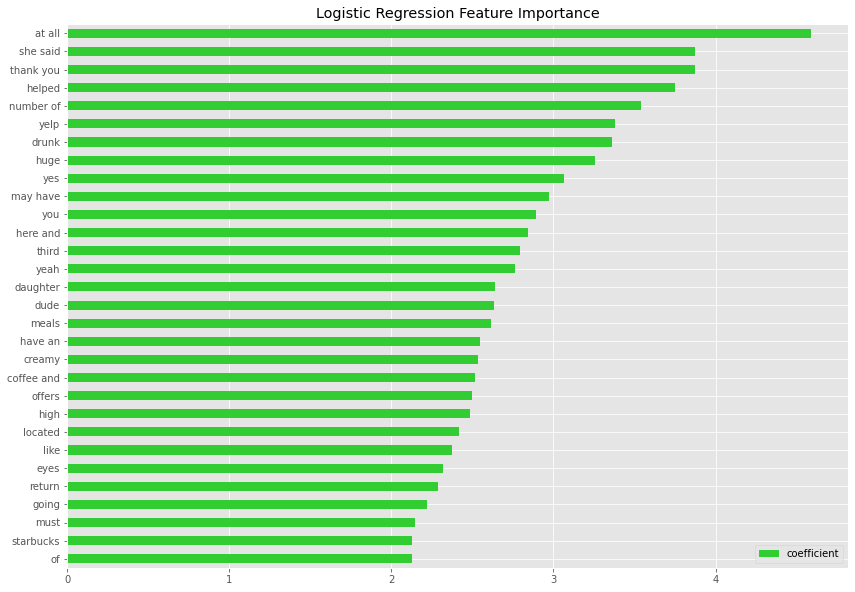

In [117]:
important_tokens[:30].sort_values(by='coefficient').plot(kind='barh', figsize = (14,10), color = 'limegreen')
plt.title('Logistic Regression Feature Importance')
plt.savefig('featureimportance.png', bbox_inches='tight')

### Random Forest ###

In [689]:
confusion_matrix(y_test, y_pred_rf)


array([[14564,  5499],
       [ 6221, 13716]])

### Gradient Boosted Logistic Regression ###

In [688]:
# confusion matrix

confusion_matrix(y_test, y_pred_gbc)


array([[15141,  4922],
       [ 5250, 14687]])

### Naive Bayes ###

In [690]:
confusion_matrix(y_test, y_pred_nb)

array([[13874,  6189],
       [ 4920, 15017]])

## Unsupervised Learning ##

In [1]:
# NMF - topic modeling to find latent

In [2]:
# LDA

## Deep Learning ##

In [311]:
## Neural Nets ##

In [10]:
# Feedforward Networks/Multi-layer Perceptrons on top of BOW representation
# 25 epochs, batch size 50?
# build word vectors using gensim, fit on top of that

import tensorflow as tf
from tensorflow.keras import layers
keras = tf.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD

In [ ]:
nn = Sequential()

n_samples, n_feats = X_train.shape

denselayer = Dense(units=1,
                input_dim=n_feats,
                kernel_initializer='uniform',
                activation='sigmoid')

nn.add(denselayer)

nn.compile(loss='log',
           optimizer='sgd',
           metrics=[Precision(), Recall(), 'accuracy'])

nn.add(Activation(tf.nn.relu)) #vs sigmoid?

nn.add(.Dropout(rate=0.5))

In [ ]:
nn.fit(x_train, y_train, epochs=10, batch_size=32)

## LSTM ##

In [162]:
# create dfs

X_train_balanced_df = X_train_balanced_df.drop(['Unnamed: 0'], axis = 1)
y_train_balanced_df = y_train_balanced_df.drop(['Unnamed: 0'], axis = 1)

,text
0,2017's Yelp 100 Challenge 18/100\n\nWhat a fun...
1,We recently leased a new car from here. We had...
2,If I could give this place one star I would. D...
3,So I seriously considered trying to impress yo...
4,"I went here based off the reviews, and the fac..."
...,...
545377,There's an older review that suggests going to...
545378,Excellent Bestbuy is the best place for all el...
545379,This is the only store I know in Austin that s...
545380,"Ok, so I finally went to see what all the hub-..."


In [173]:
(X_train_balanced_df[X_train_balanced_df.index == 100].values[0])

array(["I love the driftwood. Whenever I come here I always feel like Don Draper on a secret rendezvous to meet my mistress who will be wearing sunglasses inside and smoking cigarettes with one of those fancy long holders. \n\nI know that really I'm meeting my fat, old buddies but hey, a guy can dream...."],
      dtype=object)

In [168]:
y_train_balanced_df[y_train_balanced_df.index == 100].values[0]

array([1])

In [244]:
# function to print reviews and funny rating

def print_review(index):
    review_text = X_train_balanced_df.values[index]
    funny_or_not = y_train_balanced_df.values[index]
    if len(review_text) > 0:
        print(review_text)
        print('Funny or not:', funny_or_not)

In [245]:
print_review(100)

["I love the driftwood. Whenever I come here I always feel like Don Draper on a secret rendezvous to meet my mistress who will be wearing sunglasses inside and smoking cigarettes with one of those fancy long holders. \n\nI know that really I'm meeting my fat, old buddies but hey, a guy can dream...."]
Funny or not: [1]


In [246]:
print_review(0)

['2017\'s Yelp 100 Challenge 18/100\n\nWhat a fun place to spend any night! My friend and I had driven by this location several times and finally one night we couldn\'t agree on what to do, so we decided to stop in to grab a bite. Upon entering you are greeted by a waitress who says in the cutest accent: "seat yourself anywhere", and we did at one of the many tables located just above and to the right of the stage. They have karaoke, a full bar and a full kitchen! The drinks? A-1! The karaoke? Amazing! The food? Hit or miss. We ordered the sampler which included cheese sticks with marinara, buffalo wings, and colorful chips with spinach dip. The wings were pretty tasty, although not buffalo like we asked, had maybe a mild sauce. The cheese sticks were phenomenal, the spinach dip was flavorless and the ranch for dipping seemed like it may have been partially frozen, as in when I was trying to dip my wing it hit something hard- we moved the ranch to the side.\n\nFor our entrees, my frien

### Texting Processing ##

In [284]:
import re

REPLACE_BY_SPACE_RE = re.compile('[/{}\[\]\|@]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

In [282]:
## function for cleaning text

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    # text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    # text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('\n', ' ')
    # text = re.sub(r'\W+', '', text)
    # text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text

In [286]:
X_train_balanced_df.text = X_train_balanced_df.text.apply(clean_text)

In [294]:
print_review(0)
# can't get rid of \ ?

['2017\'s Yelp 100 Challenge 18 100  What a fun place to spend any night! My friend and I had driven by this location several times and finally one night we couldn\'t agree on what to do, so we decided to stop in to grab a bite. Upon entering you are greeted by a waitress who says in the cutest accent: "seat yourself anywhere", and we did at one of the many tables located just above and to the right of the stage. They have karaoke, a full bar and a full kitchen! The drinks? A-1! The karaoke? Amazing! The food? Hit or miss. We ordered the sampler which included cheese sticks with marinara, buffalo wings, and colorful chips with spinach dip. The wings were pretty tasty, although not buffalo like we asked, had maybe a mild sauce. The cheese sticks were phenomenal, the spinach dip was flavorless and the ranch for dipping seemed like it may have been partially frozen, as in when I was trying to dip my wing it hit something hard- we moved the ranch to the side.  For our entrees, my friend or

### Vectorization ##

In [296]:
X_train_balanced_df.text

0         2017's Yelp 100 Challenge 18 100  What a fun p...
1         We recently leased a new car from here. We had...
2         If I could give this place one star I would. D...
3         So I seriously considered trying to impress yo...
4         I went here based off the reviews, and the fac...
                                ...                        
545377    There's an older review that suggests going to...
545378    Excellent Bestbuy is the best place for all el...
545379    This is the only store I know in Austin that s...
545380    Ok, so I finally went to see what all the hub-...
545381    The always work with me on price and outstandi...
Name: text, Length: 545382, dtype: object

In [299]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250

# This is fixed
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X_train_balanced_df.text.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 273088 unique tokens.


In [306]:
X = tokenizer.texts_to_sequences(X_train_balanced_df.text.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (545382, 250)


In [308]:
y = y_train_balanced_df.values
print('Shape of label tensor:', y.shape)

Shape of label tensor: (545382, 1)


### Model

In [324]:
# train test split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(490843, 250) (490843, 1)
(54539, 250) (54539, 1)


In [325]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall')])

epochs = 5
batch_size = 64

history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
6903/6903 [==============================] - 2333s 332ms/step - loss: 0.5658 - accuracy: 0.7146 - precision: 0.7100 - recall: 0.7259 - val_loss: 0.5427 - val_accuracy: 0.7379 - val_precision: 0.7489 - val_recall: 0.7169
Epoch 2/5
6903/6903 [==============================] - 2290s 332ms/step - loss: 0.5065 - accuracy: 0.7563 - precision: 0.7562 - recall: 0.7556 - val_loss: 0.5032 - val_accuracy: 0.7542 - val_precision: 0.7369 - val_recall: 0.7917
Epoch 3/5
6903/6903 [==============================] - 2261s 328ms/step - loss: 0.4680 - accuracy: 0.7786 - precision: 0.7817 - recall: 0.7742 - val_loss: 0.5045 - val_accuracy: 0.7539 - val_precision: 0.7641 - val_recall: 0.7353
Epoch 4/5
6903/6903 [==============================] - 2259s 327ms/step - loss: 0.4351 - accuracy: 0.7973 - precision: 0.8049 - recall: 0.7838 - val_loss: 0.5220 - val_accuracy: 0.7485 - val_precision: 0.7699 - val_recall: 0.7097
Epoch 5/5
6903/6903 [==============================] - 2253s 326ms/step - loss: 

In [356]:
# ## evaluate model

# accr = model.evaluate(X_test, y_test)
# print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

In [359]:
# save the model to disk
model.save("LTSM1.h5")
# filename = 'first_LSTM.sav'
# pickle.dump(model, open(filename, 'wb'))

In [360]:
print("Original model:", model)

Original model: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f8bf1bb06d0>


In [345]:
## calculate average review length

def get_avg_length():
    total_words = 0
    for i in range(len(X_train_balanced_df)):
        total_words += len(X_train_balanced_df.text[i].split())
    return total_words / len(X_train_balanced_df)

print('Average review length:', get_avg_length())

Average review length: 157.9063683803279


In [346]:
# 2nd model

# adjust sequence length based on average review length

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 150

# This is fixed
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X_train_balanced_df.text.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(X_train_balanced_df.text.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

y = y_train_balanced_df.values
print('Shape of label tensor:', y.shape)

# train test split 

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.10, random_state = 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Found 273088 unique tokens.
Shape of data tensor: (545382, 150)
Shape of label tensor: (545382, 1)
(490843, 150) (490843, 1)
(54539, 150) (54539, 1)


In [347]:
model2 = Sequential()
model2.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model2.add(SpatialDropout1D(0.2))
model2.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall')])

epochs = 5
batch_size = 64

history = model2.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
6903/6903 [==============================] - 1887s 273ms/step - loss: 0.5544 - accuracy: 0.7217 - precision: 0.7152 - recall: 0.7397 - val_loss: 0.5219 - val_accuracy: 0.7438 - val_precision: 0.7258 - val_recall: 0.7848
Epoch 2/5
6903/6903 [==============================] - 1833s 266ms/step - loss: 0.5057 - accuracy: 0.7502 - precision: 0.7470 - recall: 0.7571 - val_loss: 0.5166 - val_accuracy: 0.7473 - val_precision: 0.7330 - val_recall: 0.7791
Epoch 3/5
6903/6903 [==============================] - 1702s 247ms/step - loss: 0.4797 - accuracy: 0.7683 - precision: 0.7694 - recall: 0.7667 - val_loss: 0.5821 - val_accuracy: 0.7012 - val_precision: 0.6591 - val_recall: 0.8354
Epoch 4/5
6903/6903 [==============================] - 1798s 260ms/step - loss: 0.4649 - accuracy: 0.7770 - precision: 0.7801 - recall: 0.7716 - val_loss: 0.5285 - val_accuracy: 0.7416 - val_precision: 0.7579 - val_recall: 0.7110
Epoch 5/5
6903/6903 [==============================] - 1714s 248ms/step - loss: 

In [350]:
## evaluate model

accr = model2.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1705/1705 [==============================] - 45s 26ms/step - loss: 0.5535 - accuracy: 0.7322 - precision: 0.7549 - recall: 0.6883
Test set
  Loss: 0.554
  Accuracy: 0.732


In [361]:
# save model

model2.save("LTSM2.h5")

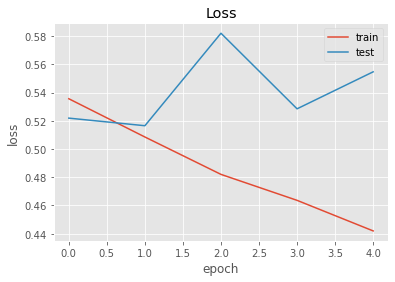

In [353]:
# plot loss

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show();

KeyError: 'acc'

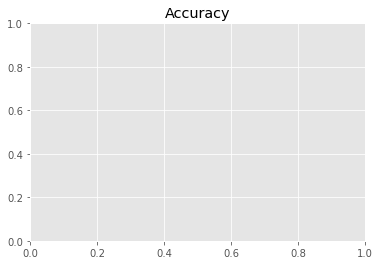

In [354]:
# plot accuracy

plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show();

In [9]:
# first on word count vectorization
import tensorflow as tf
keras = tf.keras
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import pandas as pd

%matplotlib inline

In [ ]:
# model 3: 20% of the data



## Transfer Learning ##

In [4]:
# BERT